# code testing
如果换电脑或者换平台运行这个文件，则这个code testing部分可以用来测试各个包的兼容性

In [1]:
import os
print("PYTHONPATH:", os.environ.get('PYTHONPATH'))
print("PATH:", os.environ.get('PATH'))

PYTHONPATH: None
PATH: D:\Anaconda;D:\Anaconda\Library\mingw-w64\bin;D:\Anaconda\Library\usr\bin;D:\Anaconda\Library\bin;D:\Anaconda\Scripts;D:\Program Files (x86)\IntelSWTools\compilers_and_libraries_2017.4.210\windows\mpi\intel64\bin;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\intel64_win\mpirt;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\ia32_win\mpirt;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\intel64_win\compiler;C:\Program Files (x86)\Common Files\Intel\Shared Libraries\redist\ia32_win\compiler;D:\SIMULIA\Commands;C:\Program Files\Microsoft MPI\Bin\;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files (x86)\Windows Kits\8.1\Windows Performance Toolkit\;D:\Program Files (x86)\IntelSWTools\compilers_and_libraries_2017.4.210\windows\bin\intel64;D:\Program Files (x86)\IntelSWTools\compilers_and_libraries_2017.4.210\windows\bin;

In [2]:
import keras

我们可以从下面这个例子中知道最新的utils调用方法，传统的from keras.utils.visualize_utils import plot以及from keras.vis_utils import plot的用法已经不再适用于最新版Keras（截止到2023.8.28）,目前可以使用from tensorflow.keras import utils

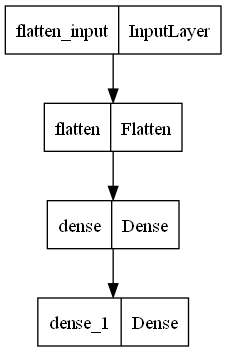

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras import datasets,layers,Sequential,losses,optimizers,utils
import keras
from keras import datasets, models, layers, utils, optimizers, Sequential
 
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
x_train,x_test=x_train/255.0,x_test/255.0
 
model = Sequential([
    layers.Flatten(input_shape=(28,28)),       # 28*28是一个图片的尺寸
    layers.Dense(128,activation="relu"),
    layers.Dense(10,activation="softmax")    
                            ])
utils.plot_model(model, to_file='model.png')

In [4]:
for n in range(100):
    print("the square of ", n, "is", n*n)
    pass
print("done")

the square of  0 is 0
the square of  1 is 1
the square of  2 is 4
the square of  3 is 9
the square of  4 is 16
the square of  5 is 25
the square of  6 is 36
the square of  7 is 49
the square of  8 is 64
the square of  9 is 81
the square of  10 is 100
the square of  11 is 121
the square of  12 is 144
the square of  13 is 169
the square of  14 is 196
the square of  15 is 225
the square of  16 is 256
the square of  17 is 289
the square of  18 is 324
the square of  19 is 361
the square of  20 is 400
the square of  21 is 441
the square of  22 is 484
the square of  23 is 529
the square of  24 is 576
the square of  25 is 625
the square of  26 is 676
the square of  27 is 729
the square of  28 is 784
the square of  29 is 841
the square of  30 is 900
the square of  31 is 961
the square of  32 is 1024
the square of  33 is 1089
the square of  34 is 1156
the square of  35 is 1225
the square of  36 is 1296
the square of  37 is 1369
the square of  38 is 1444
the square of  39 is 1521
the square of  4

([<matplotlib.axis.XTick at 0x1e4e61c5890>,
 [Text(0, 0, 'A'),
  Text(1, 0, 'B'),
  Text(2, 0, 'C'),
  Text(3, 0, 'D'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F')])

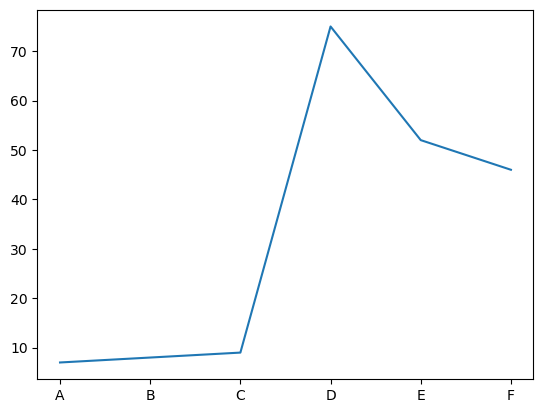

In [12]:
# 改横坐标
x_values = [0, 1, 2, 3, 4, 5]
y_values = [7, 8, 9, 75, 52, 46]


x_labels = ['A', 'B', 'C', 'D', 'E', 'F']
plt.plot(x_values, y_values)  # 绘制图形，y_values表示对应的y轴数值
plt.xticks(x_values, x_labels)  # 设置x轴的刻度值和标签

In [93]:
import re
 
name = 'E:/piloguechin/Coderlife/Pilogue/d1raw_t25.csv'
regex = re.compile(r'\d+')
num = int(max(regex.findall(name)))
print(num)

25


# Make your own network/Neural Network with Python

## 定义名为network的类

In [4]:
import numpy
# scipy.special for sigmoid function expit()
import scipy.special

In [5]:
# neural network class definition
class neuralNetwork:
    
    # initialize the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc
        self.wih = (numpy.random.rand(self.hnodes,self.inodes) - 0.5)
        self.who = (numpy.random.rand(self.onodes,self.hnodes) - 0.5)
        
        # self.wih = numpy.random.normal(0.0,pow(self.hnodes,-0.5),(self.hnodes,self.inodes))
        # self.who = numpy.random.normal(0.0,pow(self.onodes,-0.5),(self.onodes,self.hnodes))
        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
                
        pass
    
    # train the neural network
    def train(self,inputs_list,targets_list):
        # convert inputs list 2d array
        inputs = numpy.array(inputs_list,ndmin=2).T
        targets = numpy.array(targets_list,ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih,inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who,hidden_outputs)
        # calculate the signals emerging from final output layer
        final_ouputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_ouputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T,output_errors)
        
        # updated the weights for links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_ouputs * (1.0 - final_outputs)),
                                        numpy.transpose(hidden_outputs))
        
        # updated the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)),
                                        numpy.transpose(inputs)) 
        pass
    
    # query the neural network
    def query(self,input_list):
        # convert inputs list to 2d array
        input = numpy.array(input_list,ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih,inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who,hidden_outputs)
        # calculate the signals emerging from final putput layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
        pass


## 设定基本结构参数

In [12]:
    import keras
    # number of input,hidden and output nodes
    input_nodes = 784
    hidden_nodes = 100
    output_nodes = 100
    
    # learning rate is 0.3
    learning_rate = 0.3
    
    # create instance of neural network
    n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate)
    
    # load the minist training data CSV file into a list
    training_data_file = open("{0}/mnist_dataset/mnist_train_100.csv".format(current_path),"r")
    training_data_list = training_data_file.readline()
    training_data_file.close()

In [13]:
# number of input, hidden and output nodes
input_nodes = 3
hidden_nodes = 3
output_nodes = 3

# learning rate is 0.3
learning_rate = 0.3

# create instance of neural network
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

 # 数据导入及预处理


## 数据处理函数（测试前必须运行）

### 数据导入函数

In [8]:
import xlrd
import re
import os

current_path = os.getcwd()

def resd_excel(path, sheet):
    wb = xlrd.open_workbook(path)
    sheet = wb.sheet_by_name(sheet)
    regex = re.compile(r'\d+')
    num = int(max(regex.findall(path)))
    num = num / 1000
    dat = []
    for a in range(sheet.nrows):
        cells = sheet.row_values(a)
        dat.append(cells)
    return dat,num

### 总应力函数

In [10]:
import math
def total_strain(t, Emax):
    """
    
    Args:
        param1 (int): Current moment of time(t).

    Returns:
        The mechanical displacement for the current moment
        of time(t).
    """
    tc = 20.0         # Cyclic time for one cyclic loading      
    Emin = -Emax      # Maximum mechanical displacement
    tcicle = t - tc * math.floor(t / tc)
    # Calculate total strain
    if tcicle <= tc / 4.0:
        return 4.0 * (Emax / tc) * tcicle
    if tc / 4.0 < tcicle <= (3.0 / 4.0) * tc:
        return (-(4.0 * Emax) / tc) * tcicle + 2.0 * Emax
    if (3.0/4.0) * tc < tcicle <= tc:
        return ((-4.0 * Emin) / tc) * tcicle + 4.0 * Emin

## 正常导入训练数据
上面这种方法用open()函数打开excel表格，但无法解码数据，就算使用解码库更大的gb18030也不行，选择忽略部分无法解码的错误时直接集体乱码。因此选择xlrd访问文件并定义函数挨个读取数据如下，原始数据被命名为data1

### 导入训练数据

In [14]:
# 训练数据的应变幅值为±0.036
train_path = '{0}/d1raw_t36.csv'.format(current_path)
train_sheet = '1d'

data1,Amp_train = resd_excel(train_path, train_sheet)
print('训练数据应力幅为',Amp_train * 100,'%')

训练数据应力幅为 3.5999999999999996 %


## 解析数据
在这里训练数据被转化为浮点数，并取名为float_data

In [15]:
import numpy as np

data = np.array(data1)
lines = data.shape[0]
headers = data.shape[1]
print(lines, headers)
float_data = np.zeros((lines, headers))    
for i, line in enumerate(data):
    values = [float(x) for x in data[i]]   
    float_data[i, :] = values
float_data

3000 7


array([[ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.00000000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.61317403e-03, -3.53597331e+01,  9.42683741e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [16]:
float_data.shape

(3000, 7)

### 绘制应力应变曲线

<IPython.core.display.Javascript object>


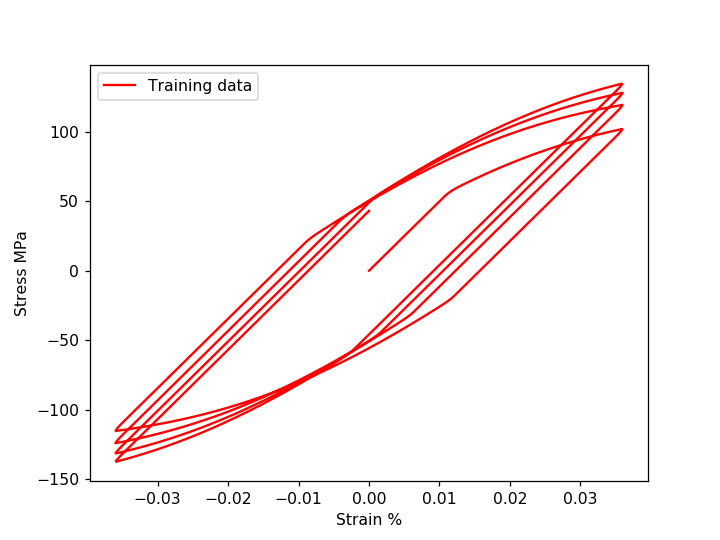

In [9]:
# 1d应力应变曲线
%matplotlib notebook
import matplotlib.pyplot as plt

strain = []
t = np.linspace(0, 80, 3000)
for i in range(len(t)):
    strain.append(total_strain(t[i],Amp_train))
stress = float_data[:, 3 ]
# plt.plot(range(len(stress)), stress)
plt.plot(strain, stress, 'r', label="Training data")
plt.xlabel("Strain %")
plt.ylabel("Stress MPa")
plt.legend()
plt.show()

#################################################

In [ ]:
# 2d应力应变曲线
strain_path = '{0}/d2strain_xx_50.csv'.format(current_path)
strain_sheet = '2d'

data1,Amp_train = resd_excel(train_path, train_sheet)

#################################################

### 标准化
标准化时对全部数据一起操作，但是只使用训练集的平均值和标准差，这样可以防止测试数据泄露给模型

In [10]:
# 对数据进行标准化，减去特征平均值，再除以标准差
mean = float_data[:1800].mean(axis=0)
float_data -= mean
std = float_data[:1800].std(axis=0)
float_data /= std

## 导入测试数据

### 测试数据导入函数

In [11]:
# 导数据预处理函数
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
global my_x_ticks
global x_labels
my_x_ticks = np.arange(0,3001,3000/8)
x_labels = np.arange(0,81,10)

# from sklearn.preprocessing import StandardScaler


def data_import(test_path,test_sheet):
    data2,Amp = resd_excel(test_path, test_sheet)
    data2

    # 解析测试数据
    data_t = np.array(data2)
    lines_t = data_t.shape[0]
    headers_t = data_t.shape[1]
    print(lines_t, headers_t)
    float_test = np.zeros((lines_t, headers_t))    
    for i, line in enumerate(data_t):
        values = [float(x) for x in data_t[i]]   
        float_test[i, :] = values
    float_test

    # 标准化数据
#     scaler = StandardScaler()
#     float_test = scaler.fit_transform(float_test)
    
    mean_t = float_test.mean(axis=0)
    float_test -= mean_t
    std_t = float_test.std(axis=0)
    float_test /= std_t

    # 简单划分
    testd1 = float_test[:, :4]
    targetd1 = float_test[:, 4:]

    # 绘制输入特征曲线
    labels = ['Evp', 'X', 'R', 'σ']
    for i,label in enumerate(labels):
        plt.plot(testd1[:, i], label=label)
    plt.xticks(my_x_ticks,x_labels)
    plt.title("1D_Standardization")
    plt.xlabel("Testing sample /s")
    plt.ylabel("stress/Mpa")
    plt.grid()
    plt.legend()
    plt.show()
    
    return  testd1, targetd1, mean_t, std_t,Amp

### 测试数据应力幅值为±0.025

3000 7


<IPython.core.display.Javascript object>


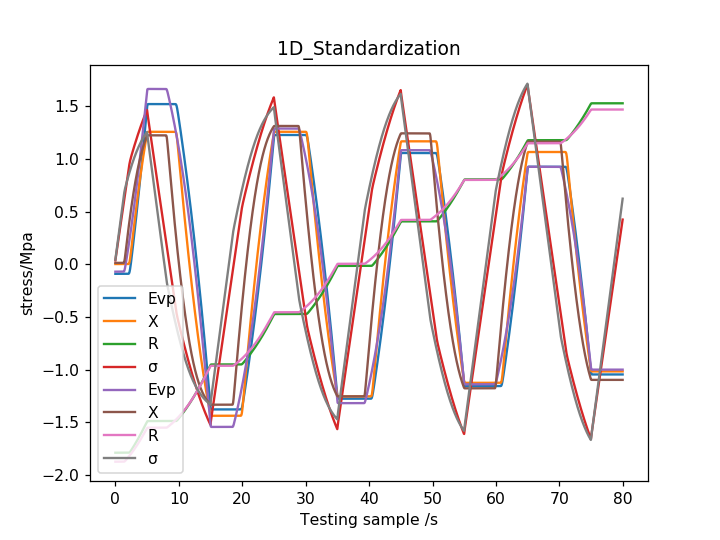

训练数据应力幅为 2.5 %


In [12]:
# 准备测试数据
test_path = '{0}/d1raw_t25.csv'.format(current_path)
test_sheet = '1d'
testd1_25,targetd1_25,mean_25,std_25,Amp_25 = data_import(test_path,test_sheet)
print('训练数据应力幅为',Amp_25 * 100,'%')

### 最终测试数据应力幅值为±0.040

3000 7


<IPython.core.display.Javascript object>


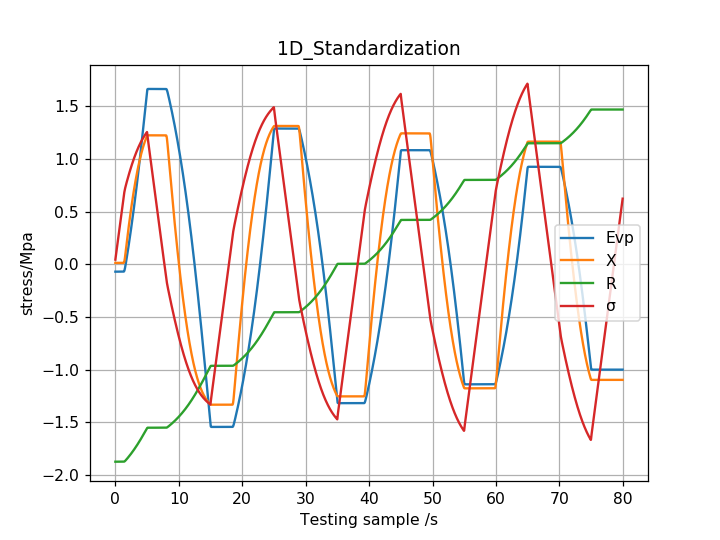

训练数据应力幅为 4.0 %


In [15]:
# 准备测试数据
test_path = '{0}/d1raw_t40.csv'.format(current_path)
test_sheet = '1d'
testd1_40,targetd1_40,mean_40,std_40,Amp_40 = data_import(test_path,test_sheet)
print('训练数据应力幅为',Amp_40 * 100,'%')

### 最终测试数据应力幅值为±0.072

3000 7


<IPython.core.display.Javascript object>


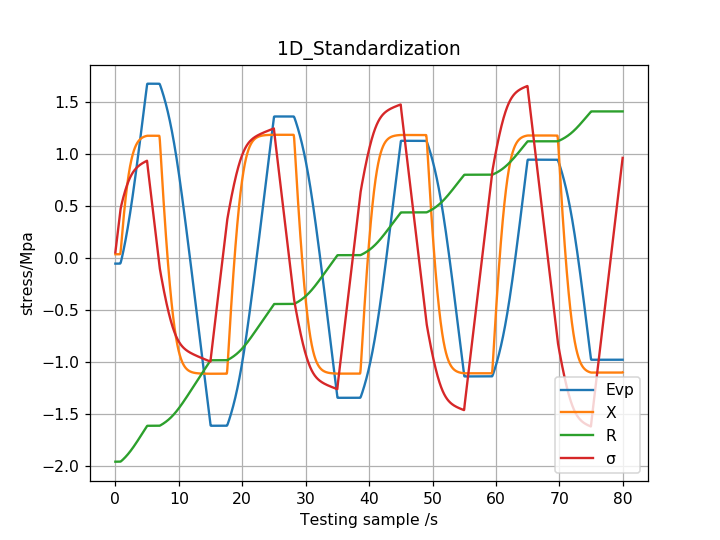

训练数据应力幅为 7.199999999999999 %


In [16]:
# 准备测试数据
test_path = '{0}/d1raw_t72.csv'.format(current_path)
test_sheet = '1d'
testd1_72,targetd1_72,mean_72,std_72,Amp_72 = data_import(test_path,test_sheet)
print('训练数据应力幅为',Amp_72 * 100,'%')

# 数据划分（弃用）

## 生成时间序列样本及其目标的生成器
生成结果为一个元组（samples，targets），其中samples是输入数据的一个批量，targets是对应的目标温度数组，参数介绍—— 
data：浮点数数据组成的原始数组，在上一步中被标准化 
lookback：输入数据应该包括过去多少个时间步 
delay：目标应该在未来多少个时间步之后 
min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步，有助于保存一部分数据用于验证，一部分用于测试 
shuffle：是打乱样本，还是按顺序抽取样本 
batch_size：每个批量的样本数 
step：数据采样的周期（单位：时间步），这里设置为1，为的是每2秒抽取75个数据点，利用上每一个数据点（这是一个仅限于大数据量下使用的参数，因为数据很多所以需要间隔取点）。

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=200, step=1):
    if max_index is None:    # 仅对测试生成器用
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:  # dead cycle
        if shuffle:    # randomly pick up each datapoint
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)    # 重复赋值，该值被r11覆盖
        else:  # pick up in order
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))    # 产生一个数列，等差为1，从i开始，到i + batch_size与max_index中比较小的那个
            i += len(rows)    # 更新i值，一开始为r4给的min_index + lookback，之后每进一次主循环就增加一个batch_size，到max_index封顶
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1] - 3))    # D1: batch_size(不封顶时); D2: timesteps; D3: characters(shape[-1]返回该数组最后一维的长度)
        targets = np.zeros((len(rows), data.shape[-1] - 4))    # D1: 长度为batch_size(不封顶时)，用于装载每个batch的目标温度 
        for j, row in  enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices, :4]
            targets[j] = data[rows[j] + delay][4:]
        yield samples, targets

## 准备训练、验证和测试生成器
generator函数实例化三个生成器：一个用于训练，一个用于验证，一个用于测试。每个生成部分分别读取原始数据的不同时间段：训练器读前2,500个时间步，验证器读取随后的1,500步，测试其读取剩下的时间步。

In [18]:
lookback = 375   # 375为1/2个周期，也就是10s
step = 1
delay = 75    # 75为1/10个周期，也就是2s
batch_size = 32

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=1800,
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=1801,
                    max_index=2400,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,     # test_gen was not used
                     lookback=lookback,
                     delay=delay,
                     min_index=2401,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size)
val_steps = (2500 - 1501 -lookback) // batch_size

test_steps = (len(float_data) - 2501 -lookback) // batch_size

需要注意的是，这里划分出来的数据只是应用于，在一段时间内，导入这段时间内前一段的数据，这个数据既为应变（输入）数据，而应力率（输出）数据并不是同一个时间点内对应的数据，而是延迟一段时间（delay）后的应力率。如果我们将延迟的时间delay设置为0，那么就是一个很常规的输入输出预测，此时就没有给定现有数据而预测下一瞬间数据的功能了。

# 模型定义与评估(弃用）

## 模型构建
首先搭建网络，通过keras模块的sequential方式组建网络，可通过model.summary()函数看到网络结构和各层网络的节点与超参数个数。同时需要注意的是，这里使用的优化算法为“rmsprop”，这种算法的特性并不是太清楚，也不知道为什么就是找不到书里提供的那个优化算法。。。还是再找找吧

In [19]:
# 模型定义
from keras import models
from keras import layers
from keras import utils

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1] - 3)))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(3))
model.compile(optimizer='rmsprop',loss='mse',metrics=['acc'])

model.summary()

#utils.plot_model(model, to_file='Fatten1d.png', show_shapes=True)

history = model.fit_generator(train_gen,
                              steps_per_epoch=103,
                              epochs=200,
                              validation_data=val_gen,
                              validation_steps=val_steps)

ModuleNotFoundError: No module named 'keras'

## 评估模型
分别可以看到损失函数与精度函数

In [20]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

<IPython.core.display.Javascript object>


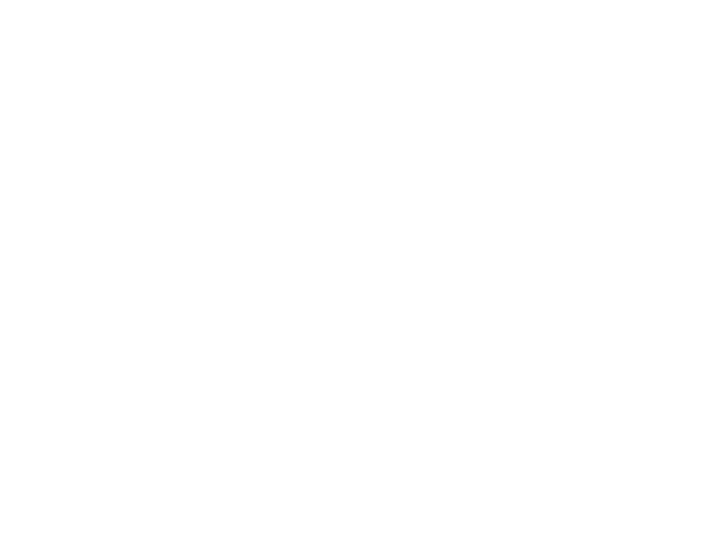

NameError: name 'history' is not defined

In [21]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 使用模型
这么使用并没有结果。

### 创建最终模型：根据上面得出的运行精度得分确定epoch和batch_size，然后正式用训练集定下模型

In [22]:
# 创建最终模型：根据上面得出的运行精度得分确定epoch和batch_size，然后正式用训练集定下模型
history = model.fit(train_gen, epochs=125, batch_size=16,verbose=0, steps_per_epoch=103)

NameError: name 'model' is not defined

In [23]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

### 测试集预测

In [18]:
# 忘记enumerate的功能呢你就看看这个，他的功能是得到一个序号表
labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rp-ann', 'rp-data']
for i, label in enumerate(labels):
    print(i, label)

0 rEvp-ann
1 rEvp-data
2 rX-ann
3 rX-data
4 rp-ann
5 rp-data


In [14]:
def my_generator():
    yield 1
    yield 2
    yield 3

这个是解决底下那个bug的关键↓↓↓,这个generator函数每次都会执行到yield然后自动中断，下一次再调用的时候又从yield开始运行，目的是在不加载整个数据集的情况下提取出数据，因为每次运行到yield就会终止，所以就算是很大的数据集（可以看成是无限循环），也只需要在适当条件下插入yield语句就可以终止。这不禁让我陷入沉思：我这一共不到五千的数据集，真的有必要整的这么花里胡哨用generator函数提取数据吗o.0？

In [15]:
gen = my_generator()
for v in gen:
    print(v)

1
2
3


In [14]:
import matplotlib.pyplot as plt

pre = model.predict(test_gen, batch_size=128, steps=val_steps)
print(pre)
print(pre.shape)

ind = range(len(pre))
# 预测值
pred = pre * std[4:] + mean[4:] # 这个std从哪儿来的？--从“标准化”中得到
# 真实值
test_targets = []
for values in test_gen:
    test_targets.append(values)
target_tsd = test_targets * std[4:] + mean[4:] # ########################### 这条有bug，问题是不知道怎么把test_gen里的targets数据整出来 ########################### #

labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rp-ann', 'rp-data']
for i, label in enumerate(labels):
    plt.plot(pred[ind, i // 2], label=label)
    plt.plot(target_tsd[ind, i // 2], label=label)
    plt.xlabel('timesteps')
    plt.legend()
plt.show()   

19/19 [==============================] - 0s 3ms/step
[[ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 ...
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]
 [ 0.64763594  0.6513996  -0.05742739]]
(608, 3)


MemoryError: Unable to allocate 375. KiB for an array with shape (32, 375, 4) and data type float64

MemoryError: Unable to allocate 375. KiB for an array with shape (32, 375, 4) and data type float64，这种神奇的报错是为什么呢？我思考了一下或许是因为for value in test_gen会无限循环调用数据生成器：test_gen，当调取了数据已经装载到375kb时，单变量存储量溢出。。。

## 保存模型

In [15]:
# save the structure and weight
model.save('model1d.h5')

del model

# recover the structure and weight
model = model.load_model('model1d.h5')
model.evaculate(test_gen)

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'model' is not defined

！！！从这开始才是有用的代码，上面的先别看了也别改了，，没啥用！！！

！！！从这开始才是有用的代码，上面的先别看了也别改了，，没啥用！！！

！！！从这开始才是有用的代码，上面的先别看了也别改了，，没啥用！！！

# 搭建网络
将数据集划分为训练集和验证集。数据少时验证集小，验证分数可能会有很大的波动，数值上表现为验证分数方差很大，这时采用K折交叉验证把数据划分为K个分区，实例化K-1个相同模型，将每个模型在K-1个分区上训练，并在剩下一个分区上评估。最终的模型验证分数取K个验证分数的平均值

## 单独划分数据集
因为上面的模型精度有些不自然，考虑到可能是数据量太小的问题，这里采用K折验证处理模型，因此不用generator函数划分数据集，而单独采用sklearn的train_test_split模块，注意，这里使用的数据应当已经标准化。当参数shuffle取True时预测精度有显著提升，但用传统的图像无法对比曲线贴合情况，也就没办法对比参数调整的准确性。

In [26]:
# from sklearn import datasets    # 这是个导入sklearn自建数据库的代码，此处没用
from sklearn.model_selection import train_test_split

# 划分数据
X = float_data[:, :4]
Y = float_data[:, 4:]

# 将原始数据划分为训练集和测试集
train_data, test_data, train_targets, test_targets = train_test_split(X, Y, train_size=0.8, shuffle=False, random_state=6)    # 注意，该函数有一个参数shuffle默认值为true，意味着取数据集时是默认打乱了来取的
train_data.shape, train_targets.shape

((2400, 4), (2400, 3))

## 模型定义
当前为Adagrad

In [27]:
# 模型定义1
from keras import models
from keras import layers

def build_model1():
    model = models.Sequential()
    model.add(layers.Dense(4, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(3))
    model.compile(optimizer='Adagrad',loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

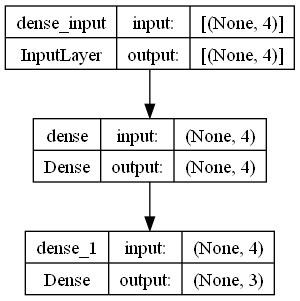

In [28]:
from keras import utils
utils.plot_model(build_model1(), to_file='dense43.png', show_shapes=True)

In [15]:
# 模型定义2
from scipy.optimize import fmin_lbfgs
from keras import models
from keras import regularizers

tf.compat.v1.disable_eager_execution()

def build_model2():
    model = models.Sequential()
    
    model.add(layers.Dense(4, activation='relu', input_shape=(None, train_data.shape[-1])))
    model.add(layers.Dense(3))
    
    metric = tf.keras.metrics.R2Score()
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss_func,method='L-BFGS-B')
    regularizer = tf.keras.regularizers.l2(0.1)  # 设置 L2 正则化因子为 0.1
    
    model.compile(optimizer=optimizer, loss=['mse'],metrics=metric, kernel_regularizer=regularizers.l2(0.1))    # mse为损失函数：均方误差，R2为评估函数：平均绝对误差,0.1为正则化因子
    return model

In [63]:
from keras import utils
utils.plot_model(build_model2(), to_file='dense_lbfgs.png', show_shapes=True)

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

In [ ]:
# 模型定义3
#################################################################################################
# 于此加入循环神经网络，利用MAP123-EP结合RNN预测塑性材料路径相关性，可以减少数据量要求

#################################################################################################

# 交叉验证

## 交叉验证
estimator	要搜索超参数的分类器
param_grid	用于搜索的参数组合，字典类型。这里有个注意点，就是字典的key必须和estimator里的参数名字保持一致，比如estimate用的svm，要调svm的参数gamma，那么param_grid里的key就必须用gamma；如果用了管道（pipeline），管道里的estimator对应的key为’svc’，那么param_grid里的可以就应该为:svc__gamma，用__来分隔，具体例子见下面。
n_jobs	搜索的时候并发度，比如n_jobs=1表示只用到一个cpu核心，n_jobs=2用到两个cpu核心，n_jobs=-1表示用到机器上的所有核心（这个和机器相关），默认为1，即只使用一个CPU核心
cv	交叉验证折数，比如cv=5，则搜索的时候每个参数组合的模型性能是由五折交叉验证算出来的均值
refit	这个参数很重要，一般要设置为true，因为这样当搜索出最佳参数后，会自动用这个最佳参数拟合出一个模型
scoring	搜索时模型性能的评价准则，默认为None，None则使用estimator的默认评价准备。也可以自己设置，比如scoring=‘roc_auc’
verbose	日志冗长度，int：冗长度，0：不输出训练过程，1：偶尔输出，>1：对每个子模型都输出。
————————————————

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 定义参数字典
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]}

# 定义模型
model = SVC()

# 使用网格搜索进行参数选择
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, refit = True, cv = 5, verbose = 1, n_jobs = -1)
grid_search.fit(train_data, train_targets)

# 输出最佳参数组合和最佳得分
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

## K折验证
我决定用MSE替代MAE作为评价函数--2023.9.29
还是算了，metrics用的是mae后面也不好改--2023.9.30

### 低epoch预测

In [29]:
# K折验证
import numpy as np

k = 5
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model_k1 = build_model1()
    model_k1.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model_k1.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [30]:
all_scores

[0.6454127430915833,
 0.8581470251083374,
 0.847307026386261,
 0.7173703908920288,
 0.7240518927574158]

In [31]:
np.mean(all_scores)

0.7584578156471252

### 增大epoch观察模型表现
从model1的4折验证结果来看，验证分数差异略大，分布在0.2到0.36之间，平均分数0.28意味着预测应力率[rEvp, rX, rp]和实际应力率相差0.28Mpa

2023.8.28计算结果

In [ ]:

from keras import models
from keras import layers
num_epochs = 10000
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model_k = build_model1()
    history = model_k.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1


In [ ]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 绘制验证分数

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

再找到曲线最低点的epoch值

In [ ]:
# 找到最小值的索引
min_index = average_mae_history.index(min(average_mae_history))

# 打印最小值的索引
print("最小值的索引:", min_index)

### 重绘验证分数
①删除前10个数据点，因为这些点取值与其他点不同 ②将每个数据点替换为前面数据点的指数移动平均值。 可以观察到MAE在几轮以后就不再降低，之后定epoch数值

In [ ]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 训练最终1d模型

In [ ]:
model = build_model1()
print(model.metrics_names)
model_fn = model.fit(train_data, train_targets, epochs=min_index, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

## 损失曲线

In [ ]:
loss = model_fn.history['loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
# 测试集结果如下
test_mae_score
predictions = model.predict(test_data, batch_size=32, verbose=1)
print(predictions)
print(predictions.shape)

## 绘制结果

In [ ]:
# 绘制结果
import matplotlib.pyplot as plt

indext = range(len(predictions))
predictions = predictions * std[4:] + mean[4:]
test_targets = test_targets * std[4:] + mean[4:]

plt.plot(indext, predictions[indext, 0], 'r', label='rEvp-ann')
plt.plot(indext, test_targets[indext, 0], 'b', label='rEvp-data')
plt.xlabel('timesteps')
plt.ylabel('')

plt.legend()
plt.show()                                                                              

In [ ]:
plt.plot(indext, predictions[indext, 1], 'y', label='rX-ann')
plt.plot(indext, test_targets[indext, 1], 'b', label='rX-data')

plt.legend()
plt.show()  

In [ ]:
plt.plot(indext, predictions[indext, 2], 'g', label='rR-ann')
plt.plot(indext, test_targets[indext, 2], 'b', label='rR-data')

plt.legend()
plt.show()  

## 保存模型

In [29]:
import pickle
# 模型文件的pickle任意的，但通常使用.pkl或.pickle
# save the structure and weight
# with open('model1d_sgd.pkl', 'wb') as f:  # 参数'wb'指定以二进制模式写入文件
#     pickle.dump(model, f)

###########################################################################################
model.save('1d_Adagrad.h5')  # 保存模型到my_model.h5文件中
###########################################################################################

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 预测

## 四函数
预测，再现，率对比，原对比

In [7]:
import keras
# 预测函数
def prediction(testd1_72,std_72,mean_72):
    # load the trained model
    ###########################################################################################
    model = keras.models.load_model('1d_Adagrad.h5')  # 从my_model.h5文件中加载模型
    ###########################################################################################
    # with open('model1d_Adagrad.pkl', 'rb') as f:
    #     model = pickle.load(f)
    
    predictions72 = model.predict(testd1_72, batch_size=32, verbose=1)
    print(predictions72)
    print(predictions72.shape)

    target72_real = targetd1_72 * std_72[4:] + mean_72[4:]
    test72_real = testd1_72 * std_72[:4] + mean_72[:4]
    
    test72_predict = predictions72 * std_72[4:] + mean_72[4:]
       
    return test72_predict,target72_real,test72_real

In [8]:
# 再现实验数据函数
def reproduce(test_predict,amplitude):
    
    Evp1 = [0,]
    X1 = [0,]
    R1 = [50,]
    stress1 = []
    strain = []
    
    t = np.linspace(0, 80, 3000)
    for i in range(len(t)):
        strain.append(total_strain(t[i],amplitude))

    for i in range(0, len(t)):
        if i == 0:  # i等于0时Evp1[0]会被覆写，Evp0被覆写为Evp1
            Evp1[i] = Evp1[i] + 80 / 3000 * test_predict[i, 0]
            X1[i] = X1[i] + 80 / 3000 * test_predict[i, 1]
            R1[i] = R1[i] + 80 / 3000 * test_predict[i, 2]        
    
        else:  # 表达式里Evpk都变成Evpk-1
            Evp1.append(Evp1[i - 1] + 80 / 3000 * test_predict[i, 0])
            X1.append(X1[i - 1] + 80 / 3000 * test_predict[i, 1])
            R1.append(R1[i - 1] + 80 / 3000 * test_predict[i, 2])
        # 预测总应力值
        stress1.append(5000 * (strain[i] - Evp1[i]))
        pass
    return Evp1, X1, R1, stress1, strain

In [9]:
from collections import OrderedDict
import numpy as np
import pandas as pd

# 再现数据与最终结果函数
def drawS(test72_predict,test72_real,Amp):
    global stress1_72
    global linestyles_dict
    global subnum
   
    Evp1_72, X1_72, R1_72, stress1_72, strain = reproduce(test72_predict,Amp)
    index = range(len(test72_predict))
    data1 = np.stack((Evp1_72, X1_72, R1_72, stress1_72), axis=1)
    print(len(data1[0]))


    linestyles_dict = OrderedDict(
        [('solid',               (0, ())),
         ('loosely dotted',      (0, (1, 10))),
         ('dotted',              (0, (1, 5))),
         ('densely dotted',      (0, (1, 1))),

         ('loosely dashed',      (0, (5, 10))),
         ('dashed',              (0, (5, 5))),
         ('densely dashed',      (0, (5, 1))),

         ('loosely dashdotted',  (0, (3, 10, 1, 10))),
         ('dashdotted',          (0, (3, 5, 1, 5))),
         ('densely dashdotted',  (0, (3, 1, 1, 1))),

         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
    
    # plot comparison
    fig = plt.figure(figsize=(11,11))
    subnum = [221, 222, 223, 224]
    titles = ['Evp', 'X', 'R', 'σ-ε']
    labels = ['Evp-ann', 'Evp-data', 'X-ann', 'X-data', 'R-ann', 'R-data', 'ann', 'data']
    
    for i,num in enumerate(subnum):
        if num != 224:     
            ax1=fig.add_subplot(num)  # 有一个基本的问题，这里前三个子图用的句柄都是ax1，相互之间会覆写
            ax1.plot(index, test72_real[index, i], 'b',linestyle=linestyles_dict['densely dotted'], label=labels[i+1])
            ax1.plot(index, data1[index, i], 'r', label=labels[i])
            plt.xticks(my_x_ticks,x_labels)
            plt.xlabel("Time /s")
            plt.title(titles[i])
            plt.legend()
        else:  
            ax4=fig.add_subplot(num)
            ax4.plot(strain, data1[index, i], 'r', label=labels[i])
            ax4.plot(strain, test72_real[index, i], 'b',linestyle=linestyles_dict['densely dotted'], label=labels[i+1])
            plt.title(titles[i])
            plt.xlabel('strain')
            plt.ylabel('stress MPa')
            plt.legend()
    
    plt.show() 

In [10]:
# 预测结果绘制函数
def drawR(test72_predict,target72_real,test72_real):
    # plot 率
    fig = plt.figure(figsize=(11,11))
    index = range(len(test72_predict))
    data_pre = np.stack((test72_predict[:, 0], test72_predict[:, 1],test72_predict[:, 2],stress1_72), axis=1)
    target_real = np.stack((target72_real[:, 0], target72_real[:, 1],target72_real[:, 2],test72_real[:, 3]), axis=1)
    
    labels = ['rEvp-ann', 'rEvp-data', 'rX-ann', 'rX-data', 'rR-ann', 'rR-data', 'σ-ann', 'σ-data']
    titles = ['rEvp', 'rX', 'rR', 'σ']
    
    for i,num in enumerate(subnum):
        ax1=fig.add_subplot(num)
        ax1.plot(index, data_pre[index, i], 'r', label=labels[i])
        ax1.plot(index, target_real[index, i], 'b',linestyle=linestyles_dict['densely dotted'], label=labels[i+1])
        plt.xticks(my_x_ticks,x_labels)
        plt.title(titles[i])
        plt.xlabel('Time /s')
        plt.legend()
        
    plt.show() 

## 25预测

In [11]:
# 25预测
test25_predict,target25_real,test25_real = prediction(testd1_25,std_25,mean_25)

94/94 [==============================] - 0s 689us/step
[[ 0.32182884  0.19958133  0.18096134]
 [ 0.32697576  0.20736772  0.17490342]
 [ 0.33212268  0.21515411  0.1688455 ]
 ...
 [ 0.6236903   0.99286616 -0.50855213]
 [ 0.63190544  1.0004143  -0.51031226]
 [ 0.64012045  1.0079623  -0.5120723 ]]
(3000, 3)


4


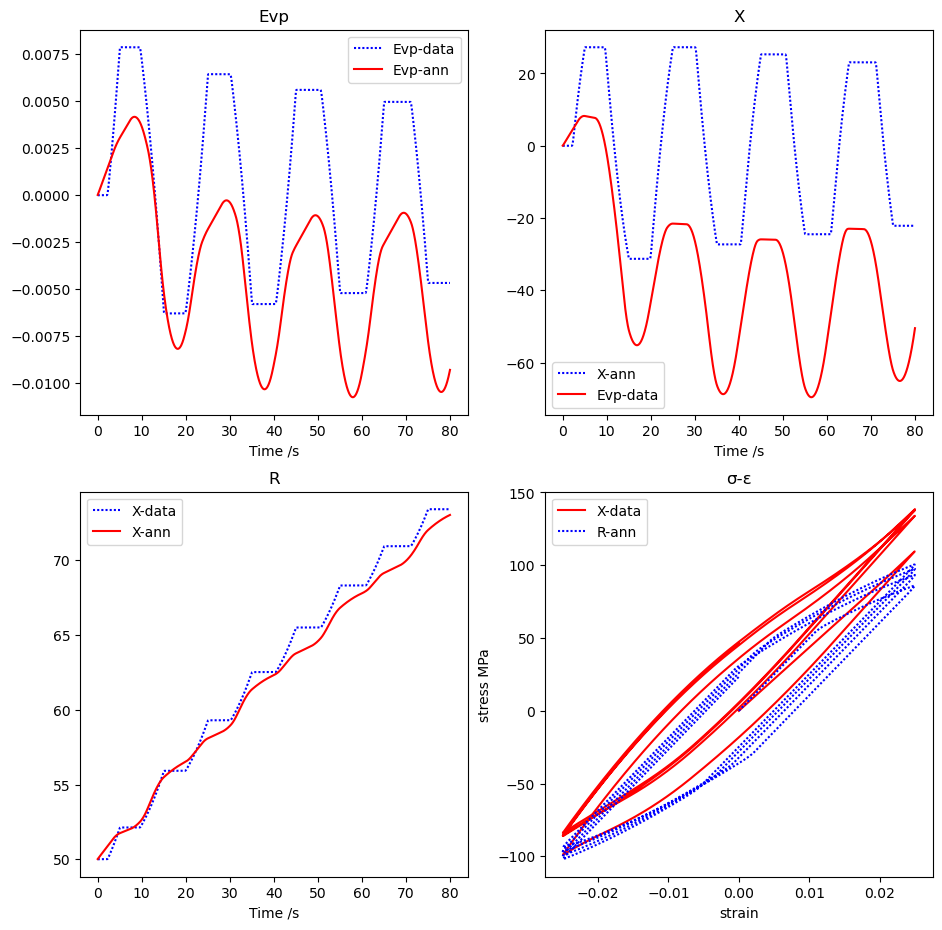

In [12]:
# 25再现数据
drawS(test25_predict,test25_real,Amp_25)

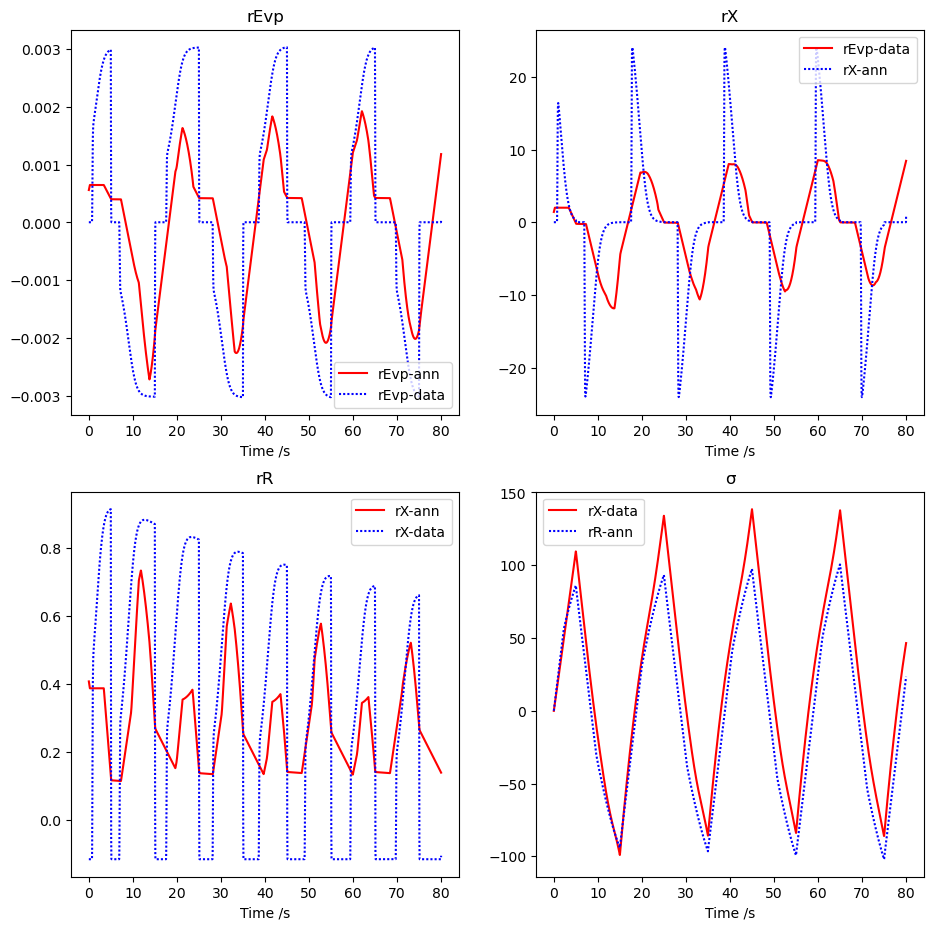

In [13]:
# 25预测结果
drawR(test25_predict,target25_real,test25_real)

## 40预测

In [14]:
# 40预测
test40_predict,target40_real,test40_real = prediction(testd1_40,std_40,mean_40)

94/94 [==============================] - 0s 667us/step
[[ 0.32378477  0.2025403   0.17865922]
 [ 0.32945186  0.2111136   0.17198907]
 [ 0.33511895  0.21968693  0.1653189 ]
 ...
 [ 0.60206544  0.92106867 -0.4504608 ]
 [ 0.6111107   0.9293796  -0.45239872]
 [ 0.62015605  0.9376905  -0.4543367 ]]
(3000, 3)


4


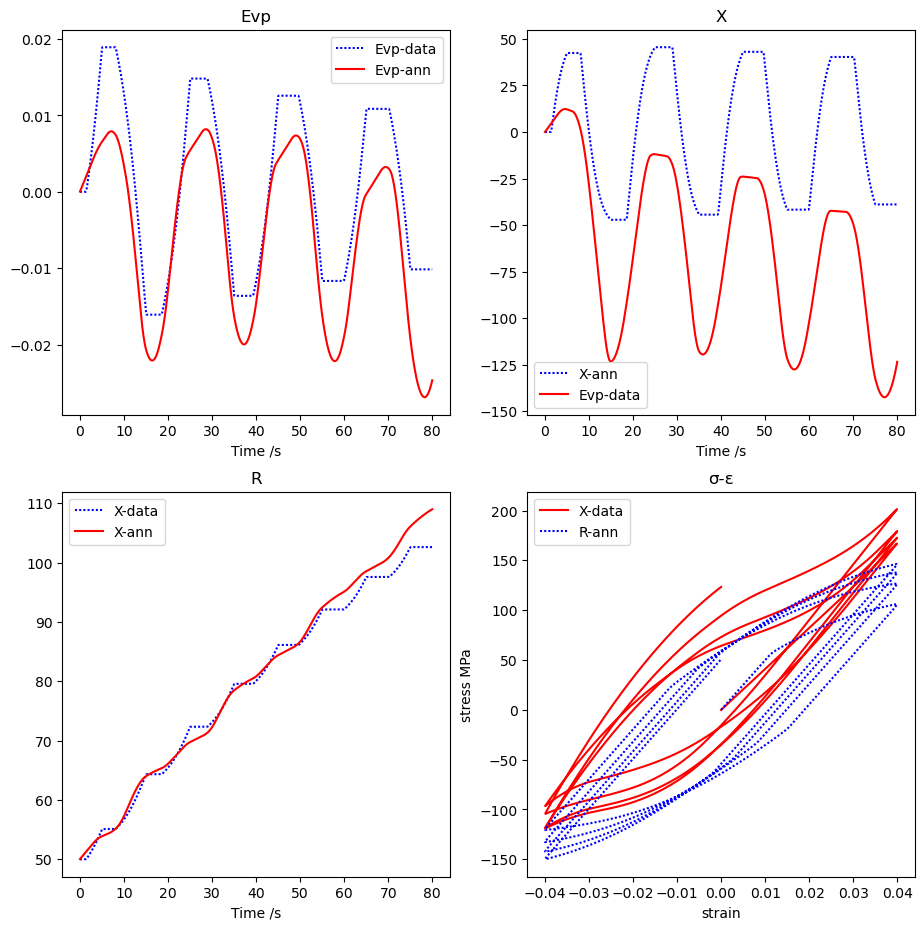

In [15]:
# 40再现数据
drawS(test40_predict,test40_real,Amp_40)

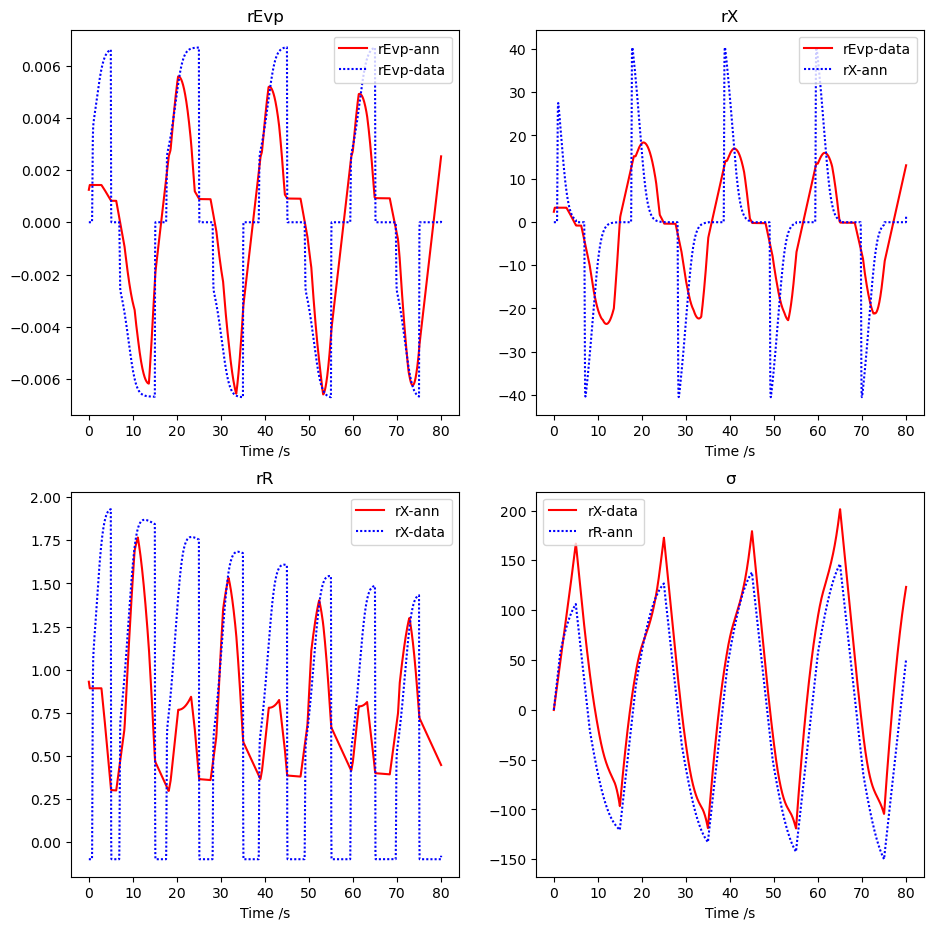

In [16]:
# 40预测结果
drawR(test40_predict,target40_real,test40_real)

## 72预测

In [17]:
# 72预测
test72_predict,target72_real,test72_real = prediction(testd1_72,std_72,mean_72)

94/94 [==============================] - 0s 665us/step
[[ 0.33558875  0.22039765  0.16476595]
 [ 0.34199208  0.23008476  0.15722924]
 [ 0.34839538  0.23977187  0.14969254]
 ...
 [ 0.69113016  0.90939116 -0.32719523]
 [ 0.69499445  0.9091315  -0.32183743]
 [ 0.69966745  0.909503   -0.3162933 ]]
(3000, 3)


4


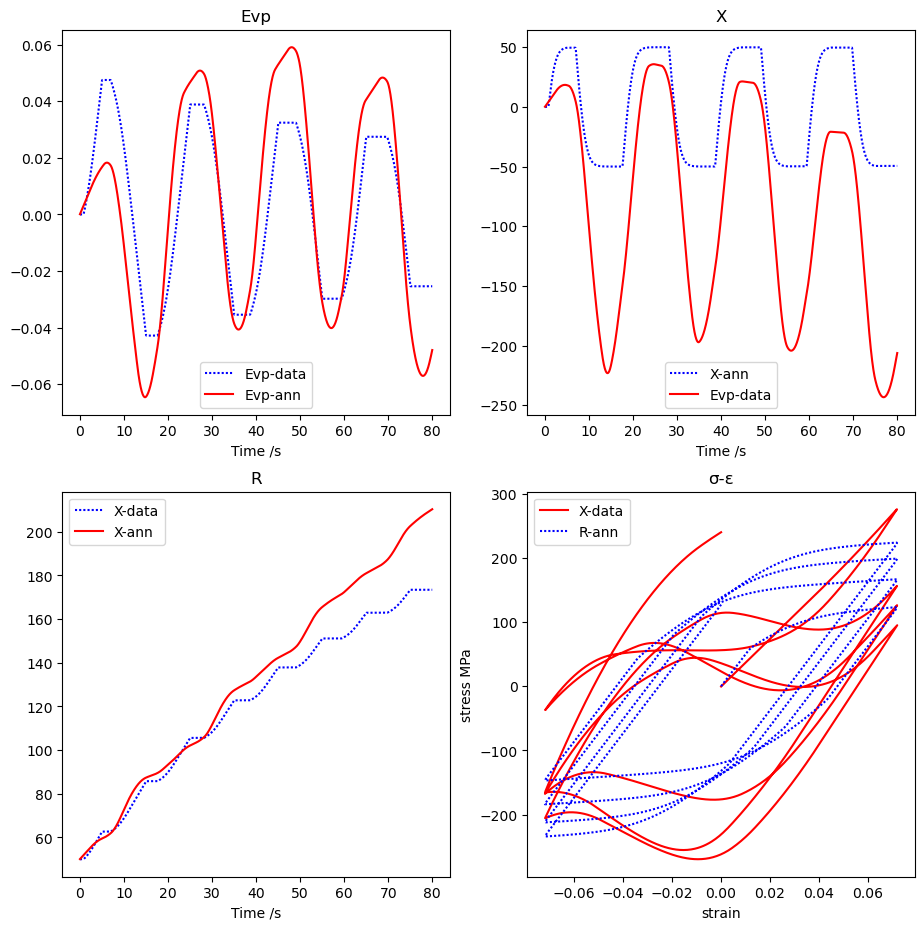

In [18]:
# 72再现数据
drawS(test72_predict,test72_real,Amp_72)

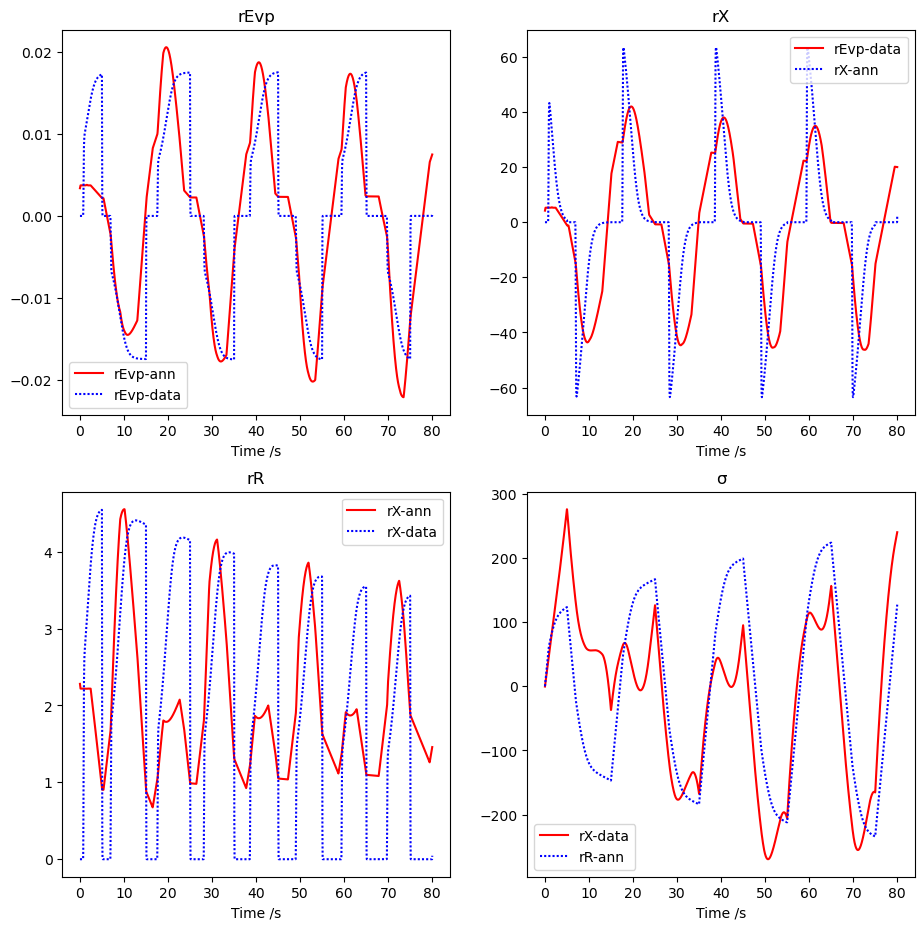

In [19]:
# 72预测结果
drawR(test72_predict,target72_real,test72_real)

# K fold validation for model2

In [37]:
# 模型定义2
from keras import models
from keras import layers
from keras.optimizers import RMSprop

def build_model2():
    model = models.Sequential()
    model.add(layers.GRU(10, return_sequences=True, input_shape=(None, train_data.shape[-1])))
    model.add(layers.Dense(3))
    model.compile(optimizer=RMSprop(), loss='mse',metrics=['mae'])    # mse为损失函数：均方误差，mae为评估函数：平均绝对误差
    return model

In [38]:
# K折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model2()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
print(all_scores, np.mean(all_scores))

processing fold # 0


ValueError: in user code:

    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Anaconda\Lib\site-packages\keras\src\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_10' (type Sequential).
    
    Input 0 of layer "gru" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (1, 4)
    
    Call arguments received by layer 'sequential_10' (type Sequential):
      • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
      • training=True
      • mask=None


## 根据得分增大epoch

In [13]:
from keras import models
from keras import layers

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model1()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## 绘制验证分数

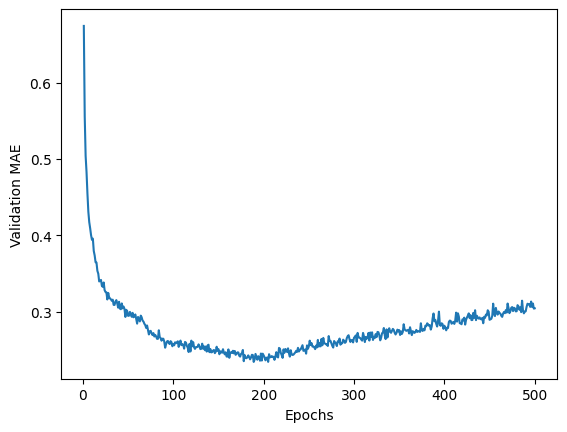

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 重绘验证分数

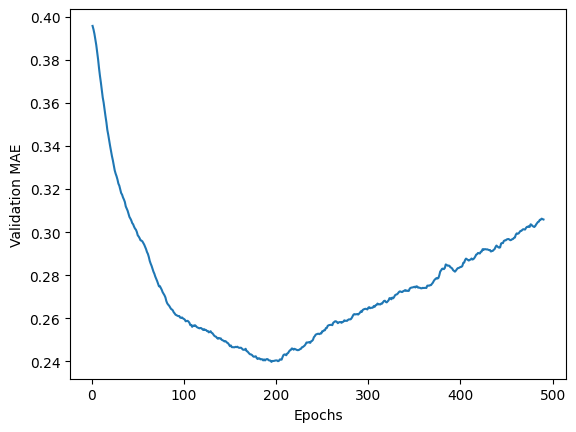

In [16]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 最终模型

In [17]:
model = build_model1()
print(model.metrics_names)
model.fit(train_data, train_targets, epochs=200, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

[]
19/19 [==============================] - 0s 5ms/step - loss: 0.0868 - mae: 0.1789


## 测试集结果

In [18]:
# 测试集结果如下
test_mae_score
predictions = model.predict(test_data, batch_size=32, verbose=1)
print(predictions)
print(predictions.shape)

19/19 [==============================] - 0s 3ms/step
[[ 1.3115643   0.6196024   0.834029  ]
 [ 1.3137611   0.6063037   0.83526665]
 [ 1.315912    0.59294605  0.8364361 ]
 ...
 [-0.07557162  0.561979   -1.0474048 ]
 [-0.07568205  0.5674405  -1.0464385 ]
 [-0.07579248  0.57290196 -1.0454721 ]]
(600, 3)
